<a href="https://colab.research.google.com/github/BastLast/DeepLearning/blob/main/Deep_Learning_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projet Deep learning

Girardin Florian, Lasteyrie Bastien, Senet Alexandre - *Tim Roquette*

## Première réflexion :

Notre première liste de stratégies pour le challenge numéro 1 est la suivante :

- CNN simple

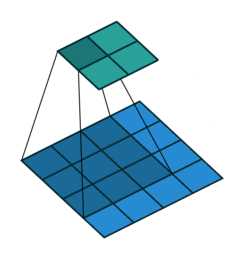

- CNN avec dilatation (stride)

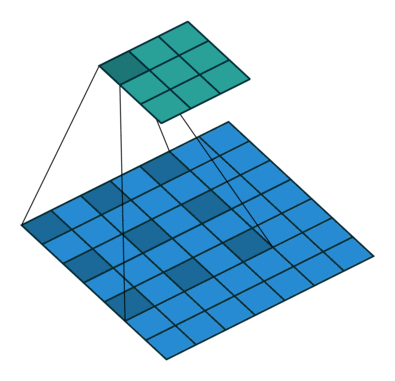

Notre théorie est que cette stratégie serait plus efficace sur les images fortement altérées et aidera quoi qu'il arrive.
Nous avons commencé avec un modèle assez simple qui utilise la partie convolution d'un CNN.
[indiquer les résultats en mode cnn avec pooling]

En enlevant les pooling, on obtietn de meilleur résultat
[indiquer les résultats en mode cnn sans pooling]

Expliqué le modèle complexifié (trouvé sur un git)

Expliqué le modèle simplifié d'alex


## Pistes étudiées :

Ressource trouvée pour débuter :
https://github.com/cszn/DnCNN et https://github.com/SonghyunYu/DIDN




In [15]:
def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR divided by 2 every 3 epochs"""
    lr = optimizer.param_groups[0]["lr"]
    if epoch % 3 == 1:
        if epoch > 1:
            lr = optimizer.param_groups[0]["lr"] / 2

    return lr

def eval(model, device, dataset_evaluated, batch_size, nb_image_to_print):
    model.to(device)
    model.eval()
    with torch.no_grad():
        general_avg = 0.0
        avg_elapsed_time = 0.0
        i = 0
        for batch_id, batch in enumerate(dataset_evaluated):
            i += 1
            images, labels = batch
            images, labels = images.to(device), labels.to(device)
            start_time = time.time()
            out_pred = model(images)
            elapsed_time = time.time() - start_time
            avg_elapsed_time += elapsed_time
            val = torch.abs(labels - out_pred).sum().cpu()
            if i<nb_image_to_print:
                fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(12, 4))
                idx = 1
                ax = fig.add_subplot(1, 3, idx, xticks=[], yticks=[])
                plt.imshow(labels[i].cpu().permute(1, 2, 0))
                ax.set_title("Labels")
                idx += 1
                ax = fig.add_subplot(1, 3, idx, xticks=[], yticks=[])
                plt.imshow(images[i].cpu().permute(1, 2, 0))
                ax.set_title("Images")
                idx += 1
                ax = fig.add_subplot(1, 3, idx, xticks=[], yticks=[])
                plt.imshow(out_pred[i].cpu().permute(1, 2, 0))
                ax.set_title("Predicted")
                idx += 1
                plt.show()
            print("Metric for a batch: " + str(val))
            print("Moyenne du batch par image: " + str(val / batch_size))
            general_avg = general_avg + (val / batch_size)
    print("Moyenne general d'une image sur le dataset évalué: " + str(general_avg / i))



In [16]:
def importDataset() :
  from google.colab import drive
  drive.mount('/content/drive')

  from google.colab import files
  import zipfile
  with zipfile.ZipFile("/content/drive/MyDrive/dataset/Tiny/train_tiny_1A.zip") as zip_ref:
    zip_ref.extractall("/content/drive/MyDrive/dataset/Tiny")

  with zipfile.ZipFile("/content/drive/MyDrive/dataset/Tiny/train_tiny_1B.zip") as zip_ref:
    zip_ref.extractall("/content/drive/MyDrive/dataset/Tiny")

  with zipfile.ZipFile("/content/drive/MyDrive/dataset/Tiny/train_tiny_2.zip") as zip_ref:
    zip_ref.extractall("/content/drive/MyDrive/dataset/Tiny")

  with zipfile.ZipFile("/content/drive/MyDrive/dataset/Test/test.zip") as zip_ref:
    zip_ref.extractall("/content/drive/MyDrive/dataset/Test")

  with zipfile.ZipFile("/content/drive/MyDrive/dataset/Full/train_1A.zip") as zip_ref:
    zip_ref.extractall("/content/drive/MyDrive/dataset/Full")

  with zipfile.ZipFile("/content/drive/MyDrive/dataset/Full/train_1B.zip") as zip_ref:
    zip_ref.extractall("/content/drive/MyDrive/dataset/Full")

  with zipfile.ZipFile("/content/drive/MyDrive/dataset/Full/train_2.zip") as zip_ref:
    zip_ref.extractall("/content/drive/MyDrive/dataset/Full")


#Uncomment the function below to import the dataset 
#importDataset()


In [17]:
def train_optim(model, device, epochs, log_frequency, learning_rate=1e-4):
    model.to(device)  # we make sure the model is on the proper device

    loss_fn = torch.nn.L1Loss()
    loss_fn.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        lr = adjust_learning_rate(optimizer, epoch)  # adjust the learning rate. Decreasing.
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr

        model.train()  # we specify that we are training the model

        start = time.time()  # start timer

        # At each epoch, the training set will be processed as a set of batches
        for batch_id, batch in enumerate(trainloader):

            images, labels = Variable(batch[0] / 255), Variable(batch[1] / 255, requires_grad=False)

            # we put the data on the same device
            images, labels = images.to(device), labels.to(device)

            y_pred = model(images)

            loss = loss_fn(y_pred, labels)

            if batch_id % log_frequency == 0:
                print(
                    "epoch: {:03d}, batch: {:03d}, loss: {:.12f}, time: {:.3f}".format(epoch + 1, batch_id + 1,
                                                                                      loss.item(),
                                                                                      time.time() - start))

            optimizer.zero_grad()  # clear the gradient before backward
            loss.backward()  # update the gradient

            optimizer.step()  # update the model parameters using the gradient


In [19]:
#Dataloader
class LoadImages(Dataset):
    def __init__(self, transformed_dataset_path : str, original_dataset_path : str) -> None:
        super(LoadImages, self).__init__()
        
        self.transformed_dataset_path = transformed_dataset_path
        self.original_dataset_path = original_dataset_path

        e1 = np.load(original_dataset_path)
        
        self.original_dataset = np.reshape(e1, (-1, 3, 96, 96))
        
        e2 = np.load(transformed_dataset_path)
        self.transformed_dataset = np.reshape(e2, (-1, 3, 96, 96))
        
        self.size = len(self.original_dataset)
            
    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):
        return (self.transformed_dataset[idx], self.original_dataset[idx])

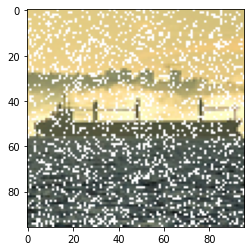

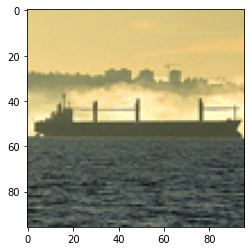

In [24]:
torch.manual_seed(1234)
o_dataset = "/content/drive/MyDrive/dataset/Tiny/train_original_tiny.npy"
t_dataset =  "/content/drive/MyDrive/dataset/Tiny/train_1A_tiny.npy"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dataset = LoadImages(t_dataset, o_dataset)
batch_size = 16
trainloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=2)
model = CustomModel()
nb_epoch = 3
log_frequency = 10
learning_rate = 1e-4
#model.load_state_dict(torch.load("/content/drive/MyDrive/modeltrained/modelTrained_2_Tiny_3epoch.pt"))
train_optim(model, device, nb_epoch, log_frequency, learning_rate)
torch.save(model.state_dict(), "/content/drive/MyDrive/modeltrained/modelTrained_1A_3epoch.pt")
eval(model, device, testloader, batch_size, 10)


**Crédit des illustrations :** https://github.com/vdumoulin/conv_arithmetic